# The $p$-innovation-ecosystems

## Heuristic model $p$-innovation ecosystems


__Director__ = Juan C. Duque

__credits__ = "Copyright (c) 2009-2021 Juan C. Duque and Daniel Restrepo"

__license__ = "New BSD License" (https://github.com/clusterpy/clusterpy/blob/master/LICENSE.txt)

__version__ = "1.0.0"

__maintainer__ = "RiSE Group"  (http://www.rise-group.org/). Universidad EAFIT

__email__ = "jduquec1@eafit.edu.co"

# 1. Exact Model

<img src="model.png" width="650" height="650" align="left">

## 1.1 Toy example

<img src="toymodel.png" width="700" align="left">

# 2. Heuristic

### 2.1 Import libraries

In [1]:
%matplotlib inline
import clusterpy
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
import math


ClusterPy: Library of spatially constrained clustering algorithms
Some functions are not available, reason: No module named Polygon
Some functions are not available, reason: No module named Polygon


### 2.2 Data reader

#### Input-output files

In [2]:
#This example is well documented and thoroughly explained in the supplementary material of the paper

shapeFile = 'shape33' #Shape to define the innovation ecosystems
production_matrix = 'matrix33.csv' #Distribution of the production within the areas of the shape
input_product_space = 'links33.csv' #Product space of reference (excel or csv)
ubiquity = 'ubiquity33.xlsx' #Ubiquity of the goods in the economy (ubiquity= 1-complexity)
dijFile = "dij33.xlsx" #Matrix of distance decay values between areas


T = 0.05  #Threshold for the product space

p= 2 #Number of regions

#### Read shape file

In [3]:
shapexy = clusterpy.importArcData(shapeFile)
shapexy.fieldNames

Loading shape33.dbf
Loading shape33.shp
Done


['ID']

In [4]:
n = len(shapexy.areas) #Number of areas

#### Distance decay function (input $d_{ij}$)

In [5]:
dijm=pd.read_excel(dijFile) #Reads the file of distances

In [6]:
#We create a dictionary with the values of dij
#Format dij[(area1,area2)]= value
#Note that these labels must match with those of shapexy
dij={}
for i in range(9):
    for j in range(9):
        dij[(i,j)]= dijm[j][i]

#### Spatial distribution of products (parameter $r_{il}$)

In [7]:
matrix = pd.read_csv(production_matrix) #NEW 
matrix=matrix.set_index('location_code')
matrix.fillna(0, inplace=True)

#### Add the relative production as an attribute of the shape file

In [8]:
prod=list(matrix.columns)
dict_matrix=matrix.to_dict()
ty = type(dict_matrix.keys()[0])
for l in prod:
    l_values = dict_matrix[ty(l)]
    attribute = {k: float(v) / total for total in (sum(l_values.itervalues(), 0.0),) for k, v in l_values.iteritems()}
    shapexy.addVariable([str(l)],attribute)
print shapexy.fieldNames

6


#### Read ubiquity/complexity

In [9]:
ub = pd.read_excel(ubiquity)
ub.set_index('i', inplace =True)
complexity = pd.DataFrame(1-ub['u'])

#### Product space function

In [10]:
def productSpace(goods, ps, complexity , T=0.05,  complexitycrit=min):
    #Goods= Available goods
    #ps= Product space of reference
    #Complexity= Complexity values per good
    # T= Threshold
    # complexitycrit= the criterion to define a node as target,i.e., its complexity is greater than or equal than at least one neighbors
    # complexitycrit=min correspondes to this latter case.

    
    
    # Product space.
    #complexity
    compmax=complexity[complexity.columns[0]].max()
    compmin=complexity[complexity.columns[0]].min()
    comp = {}              #{101: 0.49537935936493815, 102: 0.6000562838453932, 103: 0.46391192190560526,
    for i in list(complexity.index):   #normalize the complexity
        comp[int(i)] = (float(complexity[complexity.columns[0]][i])-compmin)/(compmax-compmin)
    
    #Control by the threshold (i,j, w)
    #{(307, 7322, 0.5765621752348066),(5403, 8448, 0.8123892541618876),(2823, 8467, 0.834222160825246),
    
    

    G = nx.Graph()


    PS=np.array(ps[['i','j','w']][ps['w']>T])
    PS=[(int(i),int(j),w) for (i,j,w) in PS]
    G.add_weighted_edges_from(PS)
    
    #Take giant component to guarantee conectedness

    G=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
    print "Nodes in PS", len(G.nodes())

    print "Links in PS", len(G.edges())

    #assign complexity values to nodes
    for n in G.nodes():
        try:
            G.node[n]['c'] = comp[n]  #>>>G.node[401] -> {'c': 0.49586618568114704}
        except:
            G.node[n]['c'] = 0

    #Target Nodes: GT = {2, 7, 8, 12}
    #Defining the subsets of the PS
    #Available goods
    print 'Number of goods', len(goods)
    LI0 = G.copy()
    LI0.remove_nodes_from([n for n in LI0.nodes() if n not in goods])
    print "Size available goods (LI0)", len(LI0.nodes())

    #Firstorderneigh
    GT0 = set()
    for x in LI0.nodes():
        GT0.update(set(G[x].keys()))  #neighbours of products in country
    GT0=GT0-set(goods)                  #Minus  products in country
    #If a target good only relates with an available good then it is not included in the model (removes target good 16)
    GT1 = set(x for x in list(GT0) if len(set(G[x].keys()) & set(map(int, goods))) > 1)

    #Guarantee the improving in the complexity 
    GT = set()
    for v in list(GT1):
        if comp[v] > complexitycrit(comp[x] for x in set(G[v].keys()) & set(map(int, goods))): #(strict improving)
            GT.add(int(v))

    print "Number of target nodes",len(GT)
    print "Target Nodes", GT #NEW



    #remove isolated nodes
    LI = G.copy()
    blueandgreen = set(map(int, goods))|GT
    LI.remove_nodes_from([n for n in LI.nodes() if n not in blueandgreen]) #products in country UNION target products (REVISAR)
    #print "size LI", len(LI.nodes())

    #remove isolated nodes from the list of fields in the shapefile  
    isolates = list(nx.isolates(LI))
    print "Isolated nodes", isolates



    #print "isolates", list(nx.isolates(LI))
    LI.remove_nodes_from(list(nx.isolates(LI)))
    LI.remove_nodes_from(GT)
    print "Size blue nodes", len(LI.nodes())
    finalbluegreen = set(LI.nodes())|GT
    G.remove_nodes_from([n for n in G.nodes() if n not in finalbluegreen])
    


    Waux=0
    for v in GT:
        Waux = Waux + float(len(set(G[v].keys()) & set(LI.nodes()))*(len(set(G[v].keys()) & set(LI.nodes()))-1))
    for v in G.nodes():
        if v in GT:
            G.node[v]['istarget']=1
        else:
            G.node[v]['istarget']=0   

    return G, LI, Waux,GT

In [11]:
#We read the ps data
ps = pd.read_csv(input_product_space)

#Note: Columns matrix are string, G nodes are int
#Inputs are explained at the begining of the definition of the function.

G, LI, Waux, GT = productSpace([int(a) for a in set(matrix.columns)], ps, complexity)

#Find below a summary of the information for the network G. Compare with Figure 2 in the paper.

Nodes in PS 8
Links in PS 7
Number of goods 5
Size available goods (LI0) 5
Number of target nodes 2
Target Nodes set([2, 7])
Isolated nodes []
Size blue nodes 5


# 3. Execute heuristic

In [12]:
# parameters:
# r_il: The relative relevance of the area i producing the good l
# G: Product Space
# p: number of regions
# [W1,W2]: weigths
# inits: initial solutions

### 3.1  Balancing coeffients

In [13]:
#**(1/(4*(len(shape.areas)-p)*(len(shape.areas)-p+1)*len(LI.nodes())))
h=(float(n)/(2*p))*(n-p)*Waux
W = 10**(1+math.floor(math.log(h,10)))#This is W in the exact formulation.
W1 = W/(1+W)
W2 = 1-W1   #The second term does not have coefficient, that's why we put 1.
print "W1,W2:",W1,W2

W1,W2: 0.990099009901 0.00990099009901


### 3.2  Describe Inputs


    ###### THE GEOGRAPHY ######
***** Number of areas (A): 
9
***** Index of areas (i,j): 
[0, 1, 2, 3, 4, 5, 6, 7, 8]
***** Neighbours (Ni): 
[1, 3]
***** Distance decay (f):
{(7, 3): 0.6235372149920557, (4, 7): 0.8366692041244473, (1, 3): 0.6235372149920557, (4, 8): 0.6235372149920557, (3, 0): 0.8366692041244473, (2, 8): 0.1322871615471579, (8, 0): -1.0, (7, 8): 0.8366692041244473, (5, 4): 0.8366692041244473, (0, 7): -0.1353363050482677, (5, 6): -0.1353363050482677, (2, 6): -1.0, (1, 6): -0.1353363050482677, (5, 1): 0.6235372149920557, (8, 6): 0.1322871615471579, (3, 7): 0.6235372149920557, (0, 3): 0.8366692041244473, (8, 5): 0.8366692041244473, (2, 5): 0.8366692041244473, (5, 8): 0.8366692041244473, (4, 0): 0.6235372149920557, (1, 2): 0.8366692041244473, (7, 4): 0.8366692041244473, (6, 4): 0.6235372149920557, (3, 3): 1.0, (0, 6): 0.1322871615471579, (8, 1): -0.1353363050482677, (7, 6): 0.8366692041244473, (4, 4): 1.0, (6, 3): 0.8366692041244473, (1, 5): 0.6235372149920557, (8, 8): 

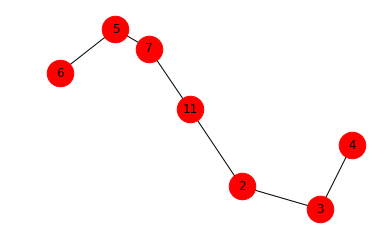

***** Set of industries in PS (G) (indexes: l,m,v):
7 [2, 3, 4, 5, 6]
***** Complexities Sample (c):
2 0.6666666666666666
3 0.5
4 0.0
5 0.33333333333333337
6 0.6666666666666666
7 0.6666666666666666
11 1.0
***** Links in PS (L):
6
***** Edge weights sample (Ylm):
(2, 11) 0.1
(2, 3) 0.1
(3, 4) 0.1
(5, 6) 0.1
(5, 7) 0.8
(7, 11) 0.2
***** Target Industries (GT):
set([2, 7])
***** Links between existing industries (LI):
2


In [14]:
print "\n    ###### THE GEOGRAPHY ######"
print "***** Number of areas (A): \n", len(shapexy.areas)
print "***** Index of areas (i,j): \n", shapexy.Y.keys()
print "***** Neighbours (Ni): \n", shapexy.Wrook[0]
print "***** Distance decay (f):\n", dij
print "***** Number of regions (p):\n", p 
print "\n    ###### THE PRODUCT SPACE ######"
print "***** Product space:\n"

#if the instance is too big for generating some of the descriptives, then take a sample of if
if len(G.nodes()) > 50:
    big = 1
    sample_nodes = map(int, shapexy.fieldNames[4:20])
    sample_graph =  G.subgraph(sample_nodes)
else:
    big = 0
    sample_graph = G.copy()
pos = nx.spring_layout(sample_graph)
nx.draw_networkx_labels(sample_graph, pos)
nx.draw_networkx_nodes(sample_graph, pos, node_size=700)
nx.draw_networkx_edges(sample_graph, pos)
plt.axis('off')
plt.show()
print "***** Set of industries in PS (G) (indexes: l,m,v):\n", len(G.nodes()), list(G.nodes())[0:5] 
print "***** Complexities Sample (c):\n", 
for n in sample_graph:
    print n,G.node[n]['c']
print "***** Links in PS (L):\n", nx.number_of_edges(G)
print "***** Edge weights sample (Ylm):\n", 
for e in sample_graph.edges():
    print e,G[e[0]][e[1]]['weight'] 
counter = 0


print "***** Target Industries (GT):\n", GT

print "***** Links between existing industries (LI):\n",len(LI.edges())



            

In [15]:
for g in G.nodes():
    print g,G.node[g]

2 {'c': 0.6666666666666666, 'istarget': 1}
3 {'c': 0.5, 'istarget': 0}
4 {'c': 0.0, 'istarget': 0}
5 {'c': 0.33333333333333337, 'istarget': 0}
6 {'c': 0.6666666666666666, 'istarget': 0}
7 {'c': 0.6666666666666666, 'istarget': 1}
11 {'c': 1.0, 'istarget': 0}


### 3.3 Execute Heuristic

In [16]:
#fields to be considered as products
fields= shapexy.fieldNames[1:]

In [17]:
#Routine for the heuristic in clusterpy
#For more details about "conTabu" and "tabuLength" please see the documentation of the p-regions model in the Clusterpy library

shapexy.cluster('pInnovationEcosystems', fields, G, p, [W1,W2], dij, fields, area2area_distance={}, inits=2, convTabu=10, tabuLength=10)

Running the p-Innovation-Ecosystem-regions algorithm
Number of areas:  9
Number of regions:  2
INITIAL SOLUTION:  [1, 1, 1, 1, 0, 1, 1, 1, 1] 
INITIAL OF:  -1.2699246742238337
-1.2699246742238337 -1.108164628302186 1
-1.2699246742238337 -1.1138668156076166 2
-1.2699246742238337 -1.0958483392709433 3
-1.2699246742238337 -1.1708097590693014 4
-1.2723342557735307 -1.2723342557735307 1
-1.2776353351828647 -1.2776353351828647 1
-1.2776353351828647 -1.1749790052501017 2
-1.2776353351828647 -1.0984988789756103 3
-1.2776353351828647 -1.11538552208375 4
-1.2776353351828647 -1.0105684196237874 5
-1.2776353351828647 -1.175227814272599 6
-1.2776353351828647 -1.0958483392709433 7
-1.2776353351828647 -1.1105742098518832 8
-1.2776353351828647 -1.2723342557735309 9
-1.2776353351828647 -1.2776353351828647 10
FINAL SOLUTION:  [1, 0, 0, 1, 0, 0, 1, 1, 0] 
FINAL OF:  -1.2776353351828647
area2area_distance has been saved in your workfile


In [18]:
def get_solution(shape):
    solucion_p_innovation = []
    for i in range(len(shape.areas)):
        solucion_p_innovation.append(shape.getVars(shape.fieldNames[-1])[i][0])
    return solucion_p_innovation

In [19]:
get_solution(shapexy)

[1, 0, 0, 1, 0, 0, 1, 1, 0]

In [24]:
def drawMap(instance, regions, W1, W2):
    instance.addVariable(['REG'], regions)
    instance.exportArcData("result")
    #Draw map
    import geopandas as gpd
    import matplotlib.pyplot as plt
    %matplotlib inline
    db = gpd.read_file('result.shp').set_index('ID')
    #db.info()
    f, ax = plt.subplots(1,figsize=(5, 5))
    db.plot(column='REG', linewidth=0.05, cmap='viridis',ax=ax)
    plt.suptitle("W1="+str(W1)+", W2="+str(W2), size=15)
    #plt.savefig('outputMap1/map.png', dpi=500)
    plt.show()

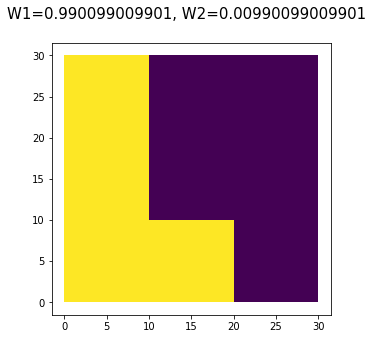

In [25]:
drawMap(shapexy, shapexy.region2areas, W1, W2)

# END